<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Targeted_Adversarial_Patch_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Attack

## Load Data from CIFAR

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparing data..


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


## Load Pretrained Model

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18  # Assuming you're using a standard architecture


In [ ]:

# Step 1: Re-declare BasicBlock and ResNet
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Step 2: Instantiate the model
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Use DataParallel
if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

# Step 3: Load the pretrained weights
# (make sure ResNet18.pt is in your working directory or give full path)
pretrained_path = "ResNet18.pt"
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Step 4: Move model to device and eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Pretrained ResNet18 loaded and ready!")

Pretrained ResNet18 loaded and ready!


## Adversarial Patch Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, train_loader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")



# # Function to evaluate the success rate of the adversarial patch and additional metrics
# def evaluate_patch(model, patch, dataloader, target_class=None):
#     model.eval()
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             patched_images = place_patch(images, patch)
#             outputs = model(patched_images)
#             _, predicted = outputs.max(1)
#             all_labels.append(labels)
#             all_predictions.append(predicted)

#     # Convert lists to tensors
#     all_labels = torch.cat(all_labels)
#     all_predictions = torch.cat(all_predictions)

#     # Compute metrics
#     accuracy = 100 * (all_predictions != all_labels).sum().item() / all_labels.size(0)
#     cm = confusion_matrix(all_labels.cpu(), all_predictions.cpu())
#     precision = precision_score(all_labels.cpu(), all_predictions.cpu(), average='weighted')
#     recall = recall_score(all_labels.cpu(), all_predictions.cpu(), average='weighted')

#     # Print results
#     print(f"Attack Success Rate: {accuracy:.2f}%")
#     print(f"Confusion Matrix:\n{cm}")
#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")

#     # ROC and AUC (if binary classification or targeting a specific class)
#     if target_class is not None:
#         # Assuming binary classification for simplicity
#         roc_auc = roc_auc_score((all_labels == target_class).cpu(), (all_predictions == target_class).cpu())
#         fpr, tpr, _ = roc_curve((all_labels == target_class).cpu(), (all_predictions == target_class).cpu())
#         print(f"ROC AUC: {roc_auc:.2f}")

#         plt.figure()
#         plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
#         plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver Operating Characteristic')
#         plt.legend(loc="lower right")
#         plt.show()



# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, target_class, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if patched_preds[i] == target_class:  # Targeted attack
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3) with target class: airplane
Epoch 1/20, Loss: 10.3679
Epoch 2/20, Loss: 8.7391
Epoch 3/20, Loss: 5.9232
Epoch 4/20, Loss: 5.4157
Epoch 5/20, Loss: 5.3025
Epoch 6/20, Loss: 5.2482
Epoch 7/20, Loss: 5.2152
Epoch 8/20, Loss: 5.2070
Epoch 9/20, Loss: 5.1879
Epoch 10/20, Loss: 5.1683
Epoch 11/20, Loss: 5.1583
Epoch 12/20, Loss: 5.1549
Epoch 13/20, Loss: 5.1586
Epoch 14/20, Loss: 5.1438
Epoch 15/20, Loss: 5.1418
Epoch 16/20, Loss: 5.1427
Epoch 17/20, Loss: 5.1359
Epoch 18/20, Loss: 5.1158
Epoch 19/20, Loss: 5.1178
Epoch 20/20, Loss: 5.1125
Visualizing patch of size (3, 3) for target class airplane


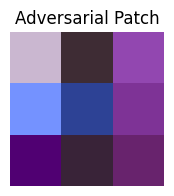

Attack Success Rate: 23.00%


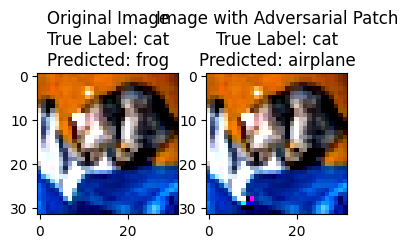

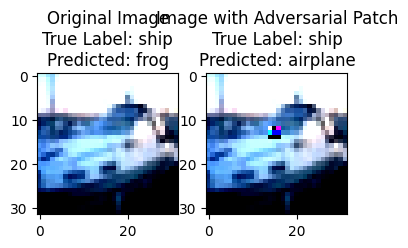

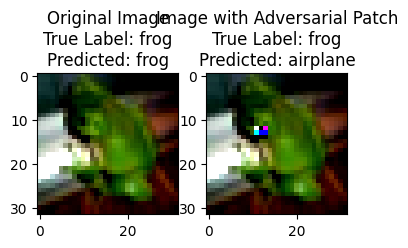

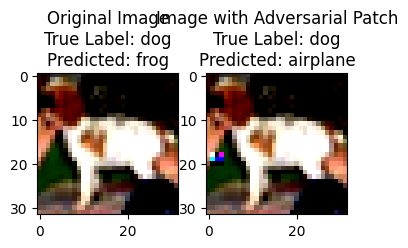

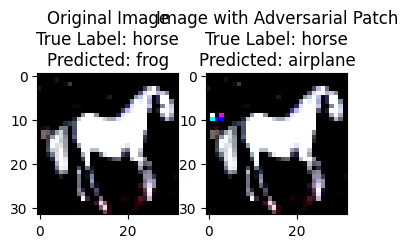


Training for patch size: (5, 5) with target class: airplane
Epoch 1/20, Loss: 9.8773
Epoch 2/20, Loss: 8.3236
Epoch 3/20, Loss: 5.8239
Epoch 4/20, Loss: 5.2191
Epoch 5/20, Loss: 5.0342
Epoch 6/20, Loss: 4.9364
Epoch 7/20, Loss: 4.8835
Epoch 8/20, Loss: 4.8553
Epoch 9/20, Loss: 4.8259
Epoch 10/20, Loss: 4.7962
Epoch 11/20, Loss: 4.7837
Epoch 12/20, Loss: 4.7557
Epoch 13/20, Loss: 4.7520
Epoch 14/20, Loss: 4.7265
Epoch 15/20, Loss: 4.7165
Epoch 16/20, Loss: 4.7092
Epoch 17/20, Loss: 4.7087
Epoch 18/20, Loss: 4.7055
Epoch 19/20, Loss: 4.6909
Epoch 20/20, Loss: 4.6976
Visualizing patch of size (5, 5) for target class airplane


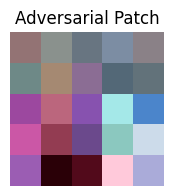

Attack Success Rate: 19.15%


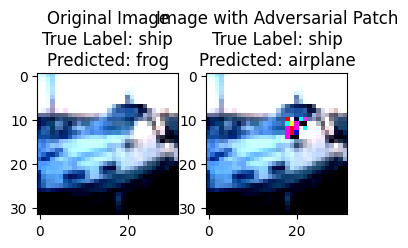

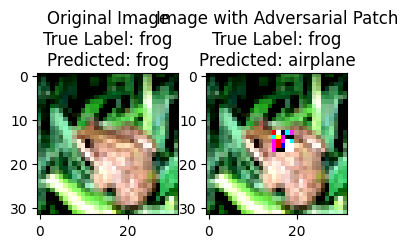

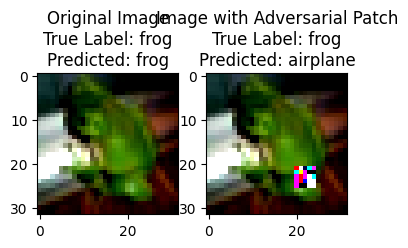

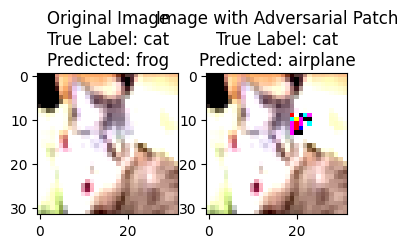

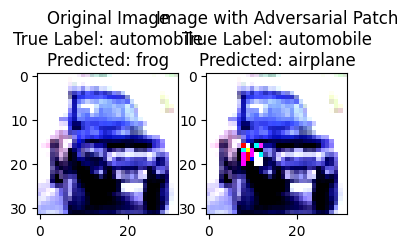


Training for patch size: (7, 7) with target class: airplane
Epoch 1/20, Loss: 9.3203
Epoch 2/20, Loss: 7.4440
Epoch 3/20, Loss: 5.3722
Epoch 4/20, Loss: 4.9833
Epoch 5/20, Loss: 4.8726
Epoch 6/20, Loss: 4.7962
Epoch 7/20, Loss: 4.7451
Epoch 8/20, Loss: 4.6767
Epoch 9/20, Loss: 4.6342
Epoch 10/20, Loss: 4.5912
Epoch 11/20, Loss: 4.5456
Epoch 12/20, Loss: 4.5040
Epoch 13/20, Loss: 4.4498
Epoch 14/20, Loss: 4.4197
Epoch 15/20, Loss: 4.3953
Epoch 16/20, Loss: 4.3690
Epoch 17/20, Loss: 4.3534
Epoch 18/20, Loss: 4.3409
Epoch 19/20, Loss: 4.3206
Epoch 20/20, Loss: 4.3133
Visualizing patch of size (7, 7) for target class airplane


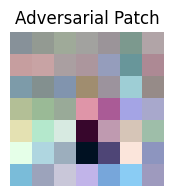

Attack Success Rate: 15.82%


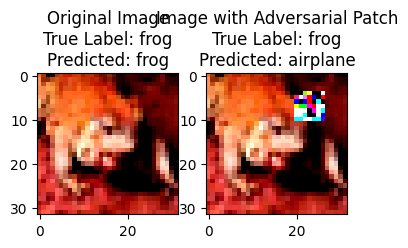

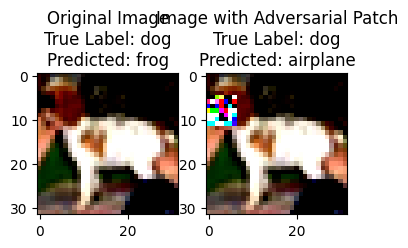

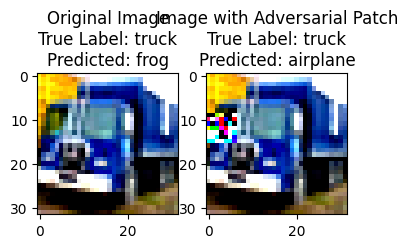

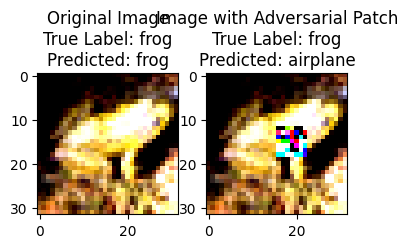

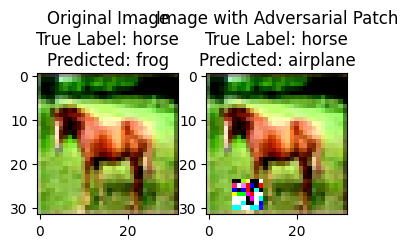


Training for patch size: (16, 16) with target class: airplane
Epoch 1/20, Loss: 6.3646
Epoch 2/20, Loss: 4.9016
Epoch 3/20, Loss: 3.8530
Epoch 4/20, Loss: 3.2203
Epoch 5/20, Loss: 2.8107
Epoch 6/20, Loss: 2.5688
Epoch 7/20, Loss: 2.4320
Epoch 8/20, Loss: 2.3394
Epoch 9/20, Loss: 2.2621
Epoch 10/20, Loss: 2.2053
Epoch 11/20, Loss: 2.1556
Epoch 12/20, Loss: 2.1137
Epoch 13/20, Loss: 2.0876
Epoch 14/20, Loss: 2.0573
Epoch 15/20, Loss: 2.0345
Epoch 16/20, Loss: 2.0082
Epoch 17/20, Loss: 1.9826
Epoch 18/20, Loss: 1.9631
Epoch 19/20, Loss: 1.9466
Epoch 20/20, Loss: 1.9247
Visualizing patch of size (16, 16) for target class airplane


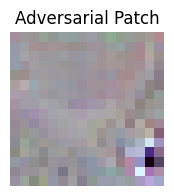

Attack Success Rate: 65.19%


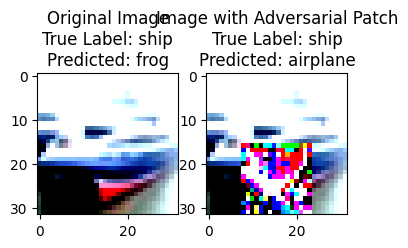

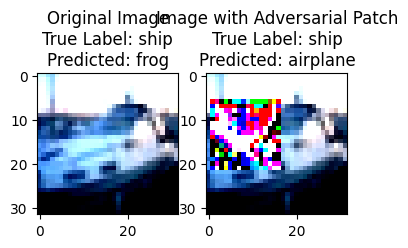

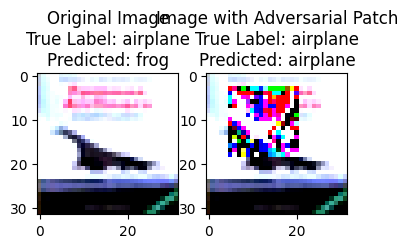

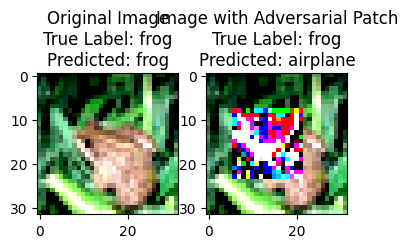

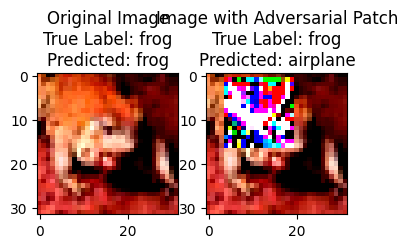


Training for patch size: (3, 3) with target class: automobile
Epoch 1/20, Loss: 10.6977
Epoch 2/20, Loss: 9.4848
Epoch 3/20, Loss: 6.6047
Epoch 4/20, Loss: 5.6095
Epoch 5/20, Loss: 5.4106
Epoch 6/20, Loss: 5.3062
Epoch 7/20, Loss: 5.2376
Epoch 8/20, Loss: 5.1918
Epoch 9/20, Loss: 5.1575
Epoch 10/20, Loss: 5.1272
Epoch 11/20, Loss: 5.0820
Epoch 12/20, Loss: 5.0782
Epoch 13/20, Loss: 5.0591
Epoch 14/20, Loss: 5.0570
Epoch 15/20, Loss: 5.0406
Epoch 16/20, Loss: 5.0443
Epoch 17/20, Loss: 5.0329
Epoch 18/20, Loss: 5.0197
Epoch 19/20, Loss: 5.0227
Epoch 20/20, Loss: 5.0279
Visualizing patch of size (3, 3) for target class automobile


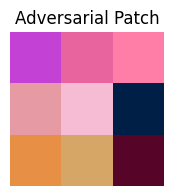

Attack Success Rate: 18.66%


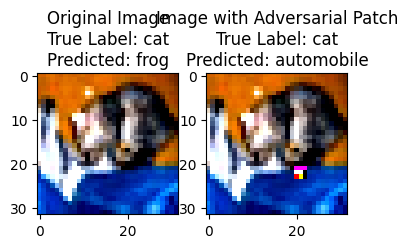

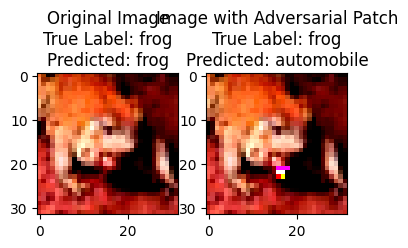

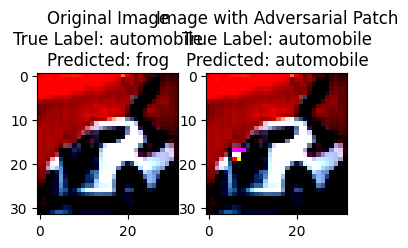

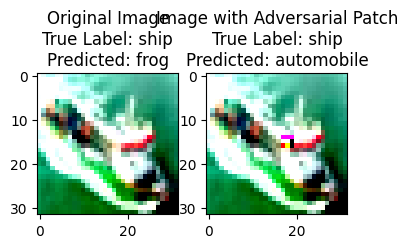

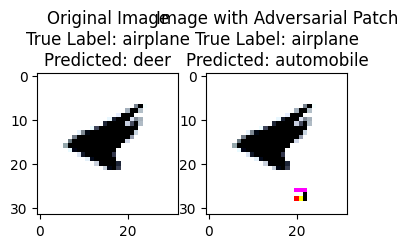


Training for patch size: (5, 5) with target class: automobile
Epoch 1/20, Loss: 9.8736
Epoch 2/20, Loss: 7.4234
Epoch 3/20, Loss: 5.1829
Epoch 4/20, Loss: 4.8877
Epoch 5/20, Loss: 4.7797
Epoch 6/20, Loss: 4.7185
Epoch 7/20, Loss: 4.6524
Epoch 8/20, Loss: 4.6271
Epoch 9/20, Loss: 4.6011
Epoch 10/20, Loss: 4.5919
Epoch 11/20, Loss: 4.5788
Epoch 12/20, Loss: 4.5656
Epoch 13/20, Loss: 4.5511
Epoch 14/20, Loss: 4.5502
Epoch 15/20, Loss: 4.5345
Epoch 16/20, Loss: 4.5262
Epoch 17/20, Loss: 4.5299
Epoch 18/20, Loss: 4.5165
Epoch 19/20, Loss: 4.5209
Epoch 20/20, Loss: 4.5046
Visualizing patch of size (5, 5) for target class automobile


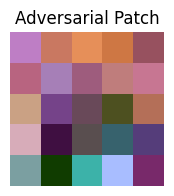

Attack Success Rate: 33.32%


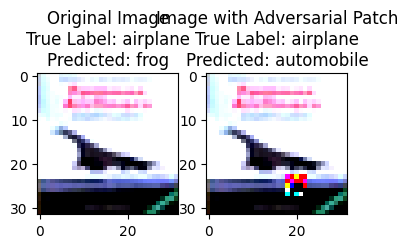

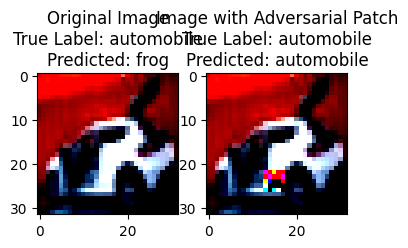

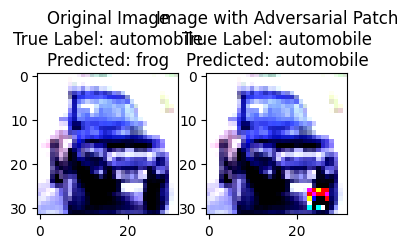

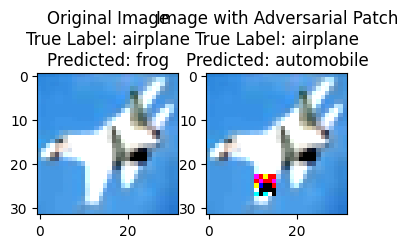

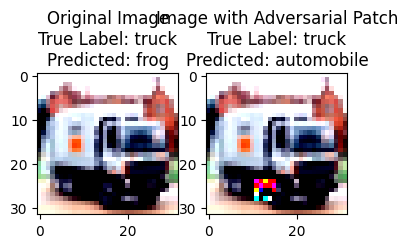


Training for patch size: (7, 7) with target class: automobile
Epoch 1/20, Loss: 9.2412
Epoch 2/20, Loss: 6.8319
Epoch 3/20, Loss: 5.0519
Epoch 4/20, Loss: 4.7578
Epoch 5/20, Loss: 4.6613
Epoch 6/20, Loss: 4.6033
Epoch 7/20, Loss: 4.5527
Epoch 8/20, Loss: 4.5184
Epoch 9/20, Loss: 4.4986
Epoch 10/20, Loss: 4.4778
Epoch 11/20, Loss: 4.4484
Epoch 12/20, Loss: 4.4351
Epoch 13/20, Loss: 4.4162
Epoch 14/20, Loss: 4.4098
Epoch 15/20, Loss: 4.3871
Epoch 16/20, Loss: 4.3720
Epoch 17/20, Loss: 4.3517
Epoch 18/20, Loss: 4.3259
Epoch 19/20, Loss: 4.3256
Epoch 20/20, Loss: 4.3219
Visualizing patch of size (7, 7) for target class automobile


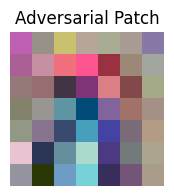

Attack Success Rate: 38.00%


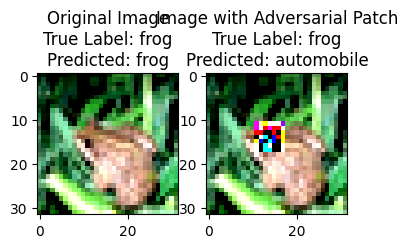

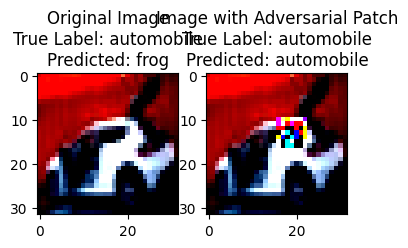

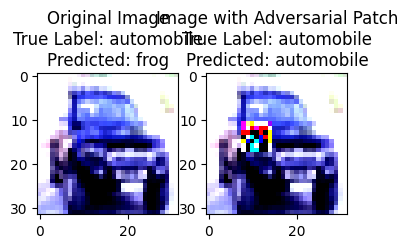

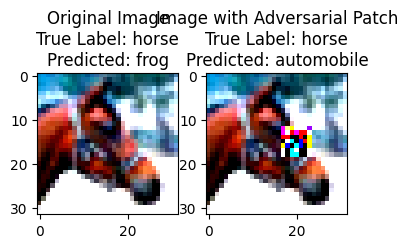

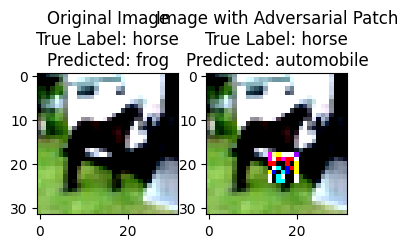


Training for patch size: (16, 16) with target class: automobile
Epoch 1/20, Loss: 4.8389
Epoch 2/20, Loss: 3.6896
Epoch 3/20, Loss: 3.1588
Epoch 4/20, Loss: 2.7980
Epoch 5/20, Loss: 2.5875
Epoch 6/20, Loss: 2.4595
Epoch 7/20, Loss: 2.3796
Epoch 8/20, Loss: 2.3067
Epoch 9/20, Loss: 2.2519
Epoch 10/20, Loss: 2.1985
Epoch 11/20, Loss: 2.1566
Epoch 12/20, Loss: 2.1190
Epoch 13/20, Loss: 2.0890
Epoch 14/20, Loss: 2.0695
Epoch 15/20, Loss: 2.0453
Epoch 16/20, Loss: 2.0287
Epoch 17/20, Loss: 2.0060
Epoch 18/20, Loss: 1.9913
Epoch 19/20, Loss: 1.9746
Epoch 20/20, Loss: 1.9702
Visualizing patch of size (16, 16) for target class automobile


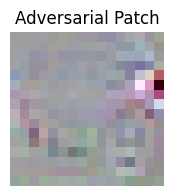

Attack Success Rate: 51.45%


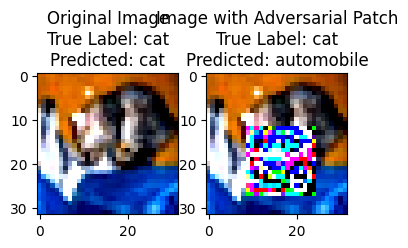

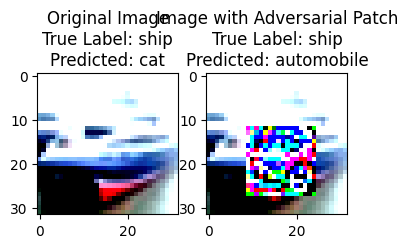

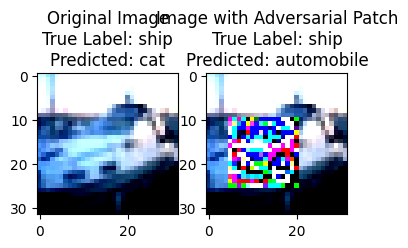

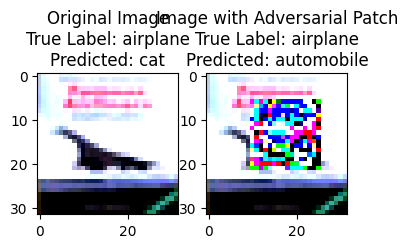

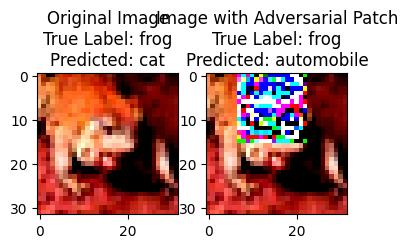


Training for patch size: (3, 3) with target class: bird
Epoch 1/20, Loss: 9.6152
Epoch 2/20, Loss: 7.9356
Epoch 3/20, Loss: 5.3857
Epoch 4/20, Loss: 4.8611
Epoch 5/20, Loss: 4.7599
Epoch 6/20, Loss: 4.6905
Epoch 7/20, Loss: 4.6517
Epoch 8/20, Loss: 4.6345
Epoch 9/20, Loss: 4.6218
Epoch 10/20, Loss: 4.6030
Epoch 11/20, Loss: 4.5837
Epoch 12/20, Loss: 4.5682
Epoch 13/20, Loss: 4.5461
Epoch 14/20, Loss: 4.5527
Epoch 15/20, Loss: 4.5335
Epoch 16/20, Loss: 4.5418
Epoch 17/20, Loss: 4.5270
Epoch 18/20, Loss: 4.5187
Epoch 19/20, Loss: 4.5289
Epoch 20/20, Loss: 4.5090
Visualizing patch of size (3, 3) for target class bird


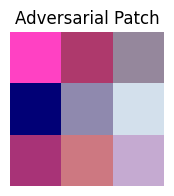

Attack Success Rate: 12.54%


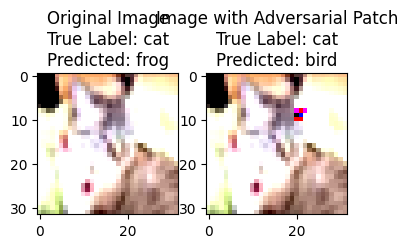

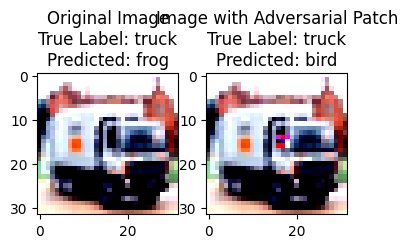

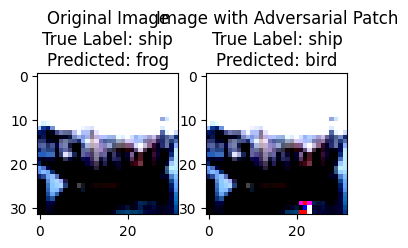

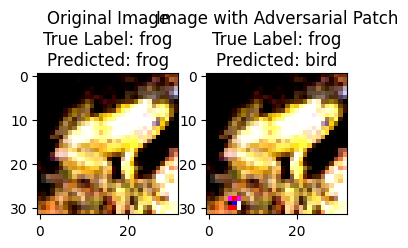

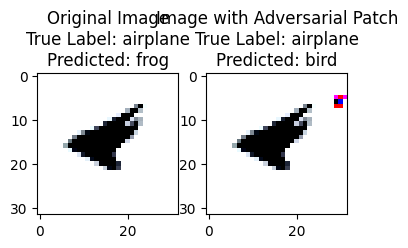


Training for patch size: (5, 5) with target class: bird
Epoch 1/20, Loss: 8.9504
Epoch 2/20, Loss: 6.7591
Epoch 3/20, Loss: 4.9824
Epoch 4/20, Loss: 4.7500
Epoch 5/20, Loss: 4.6430
Epoch 6/20, Loss: 4.5764
Epoch 7/20, Loss: 4.4946
Epoch 8/20, Loss: 4.4314
Epoch 9/20, Loss: 4.3885
Epoch 10/20, Loss: 4.3707
Epoch 11/20, Loss: 4.3404
Epoch 12/20, Loss: 4.3266
Epoch 13/20, Loss: 4.3059
Epoch 14/20, Loss: 4.2921
Epoch 15/20, Loss: 4.2716
Epoch 16/20, Loss: 4.2587
Epoch 17/20, Loss: 4.2464
Epoch 18/20, Loss: 4.2374
Epoch 19/20, Loss: 4.2163
Epoch 20/20, Loss: 4.2113
Visualizing patch of size (5, 5) for target class bird


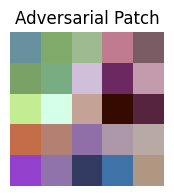

Attack Success Rate: 13.98%


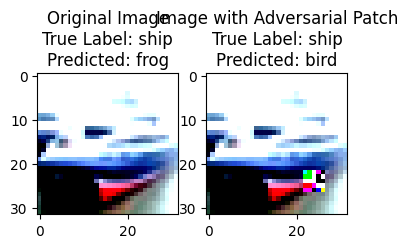

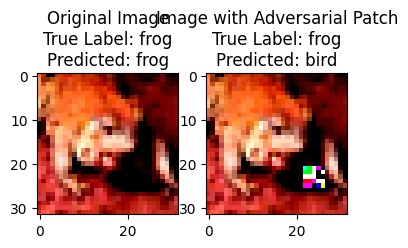

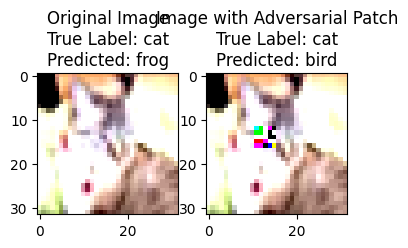

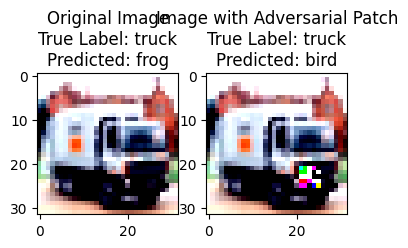

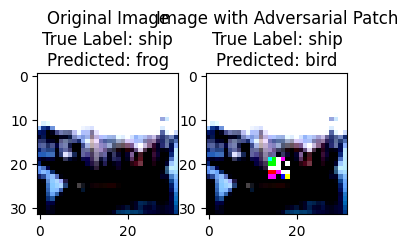


Training for patch size: (7, 7) with target class: bird
Epoch 1/20, Loss: 8.3883
Epoch 2/20, Loss: 6.6278
Epoch 3/20, Loss: 4.9413
Epoch 4/20, Loss: 4.5075
Epoch 5/20, Loss: 4.3482
Epoch 6/20, Loss: 4.2712
Epoch 7/20, Loss: 4.2278
Epoch 8/20, Loss: 4.1891
Epoch 9/20, Loss: 4.1474
Epoch 10/20, Loss: 4.1158
Epoch 11/20, Loss: 4.0993
Epoch 12/20, Loss: 4.0667
Epoch 13/20, Loss: 4.0448
Epoch 14/20, Loss: 4.0126
Epoch 15/20, Loss: 3.9876
Epoch 16/20, Loss: 3.9790
Epoch 17/20, Loss: 3.9659
Epoch 18/20, Loss: 3.9350
Epoch 19/20, Loss: 3.9183
Epoch 20/20, Loss: 3.8979
Visualizing patch of size (7, 7) for target class bird


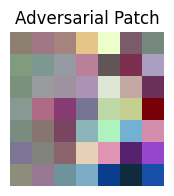

Attack Success Rate: 24.65%


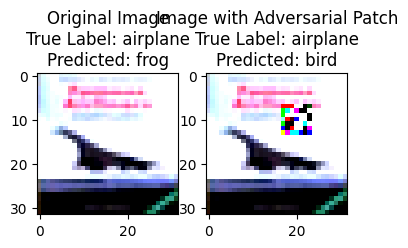

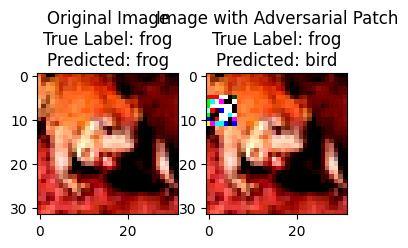

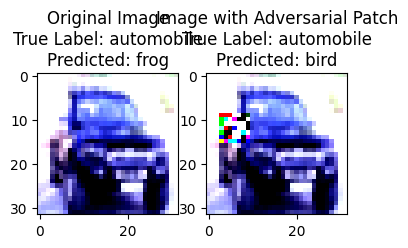

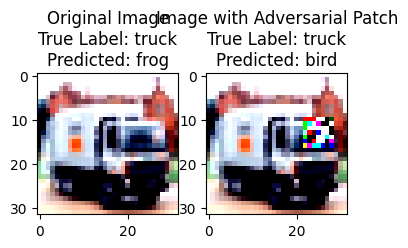

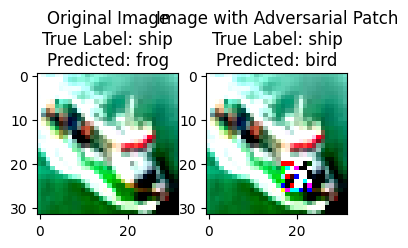


Training for patch size: (16, 16) with target class: bird
Epoch 1/20, Loss: 5.7422
Epoch 2/20, Loss: 4.5346
Epoch 3/20, Loss: 3.9044
Epoch 4/20, Loss: 3.5108
Epoch 5/20, Loss: 3.2577
Epoch 6/20, Loss: 3.0758
Epoch 7/20, Loss: 2.9325
Epoch 8/20, Loss: 2.8196
Epoch 9/20, Loss: 2.7338
Epoch 10/20, Loss: 2.6400
Epoch 11/20, Loss: 2.5502
Epoch 12/20, Loss: 2.4483
Epoch 13/20, Loss: 2.3414
Epoch 14/20, Loss: 2.2277
Epoch 15/20, Loss: 2.1401
Epoch 16/20, Loss: 2.0679
Epoch 17/20, Loss: 2.0075
Epoch 18/20, Loss: 1.9478
Epoch 19/20, Loss: 1.8824
Epoch 20/20, Loss: 1.8306
Visualizing patch of size (16, 16) for target class bird


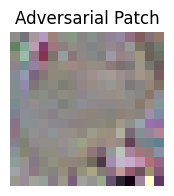

Attack Success Rate: 59.45%


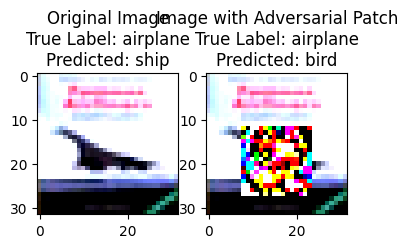

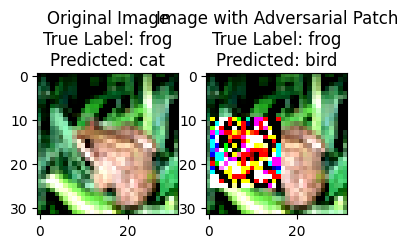

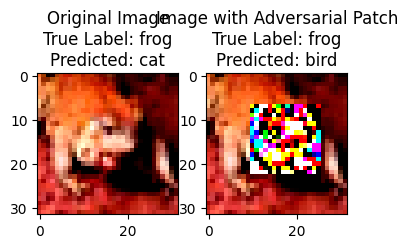

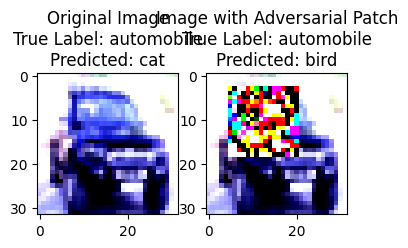

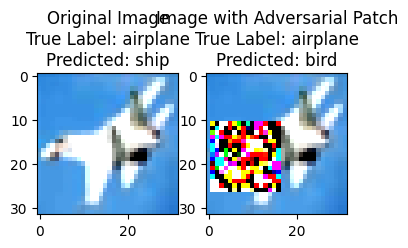

In [ ]:

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Targeted classes (plane, car, bird)
target_classes = [0, 1, 2]  # Corresponding to 'airplane', 'automobile', 'bird'

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches for each target class
for target_class in target_classes:
    for patch_size in patch_sizes:
        print(f"\nTraining for patch size: {patch_size} with target class: {classes[target_class]}")
        patch = create_patch(patch_size)
        train_adversarial_patch(model, patch, target_class=target_class, num_epochs=20)

        # Save the patch
        torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}_target_{target_class}.pth')

        # Visualize the patch
        print(f"Visualizing patch of size {patch_size} for target class {classes[target_class]}")
        visualize_patch(patch)

        # Evaluate attack success rate
        evaluate_patch(model, patch, test_loader, target_class=target_class)

        # Visualize misclassified examples with the adversarial patch
        visualize_misclassified_patched_images(model, patch, test_loader, classes, target_class, num_examples=5)